In [17]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from config import *
from sanity_functions import *

### Train

In [18]:
train = pd.read_csv(DATA_PATH / 'case_study_training.csv')
train.head()

,City,Website,Revenue,Status,Value
0,Harrisburg,https://www.paiolta.org/,"$25,000,001 to $100,000,000",Other,0
1,Santa Fe Springs,http://WWW.OXYHEALTH.COM,"$7,500,001 to $25,000,000",Private,0
2,Milford Mill,http://www.lsfrontiers.com/#xl_About:32Us,"$7,500,001 to $25,000,000",Non Profit,0
3,Harrisburg,http://www.wethepeoplepaaction.org/,"$1 to $500,000",Private,0
4,Boca Raton,https://hermanlaw.com/,"$500,001 to $7,500,000",Other,0


In [19]:
caract_df(train)

Nº rows: 2000
Nº columns: 5
Nº duplicated rows: 0

Nº of missings*:
(*) Before processing


In [20]:
data_info = pd.concat([pd.DataFrame(train.dtypes).T.rename(index={0:'column type'}),pd.DataFrame(train.isnull().sum()).T.rename(index={0:'nº nulls'}),
                       pd.DataFrame(train.isnull().sum()/train.shape[0]*100).T.
                      rename(index={0:'% nulls'}),pd.DataFrame(train.nunique()).T.rename(index={0:'nº unique values'})])

data_info

,City,Website,Revenue,Status,Value
column type,object,object,object,object,int64
nº nulls,0,0,0,0,0
% nulls,0.0,0.0,0.0,0.0,0.0
nº unique values,890,1993,7,3,2


In [21]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Value,2000.0,0.1165,0.320904,0.0,0.0,0.0,0.0,1.0


Mostrando as maiores categorias de 890


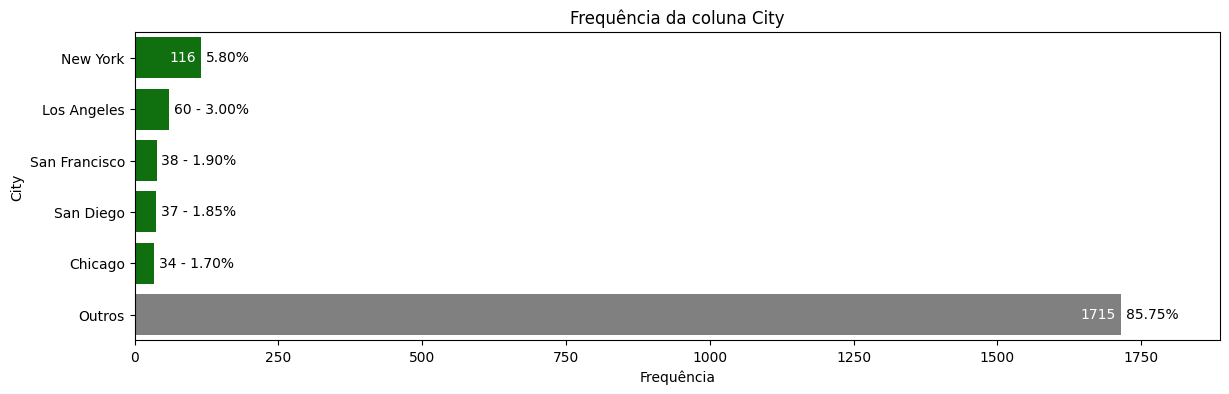

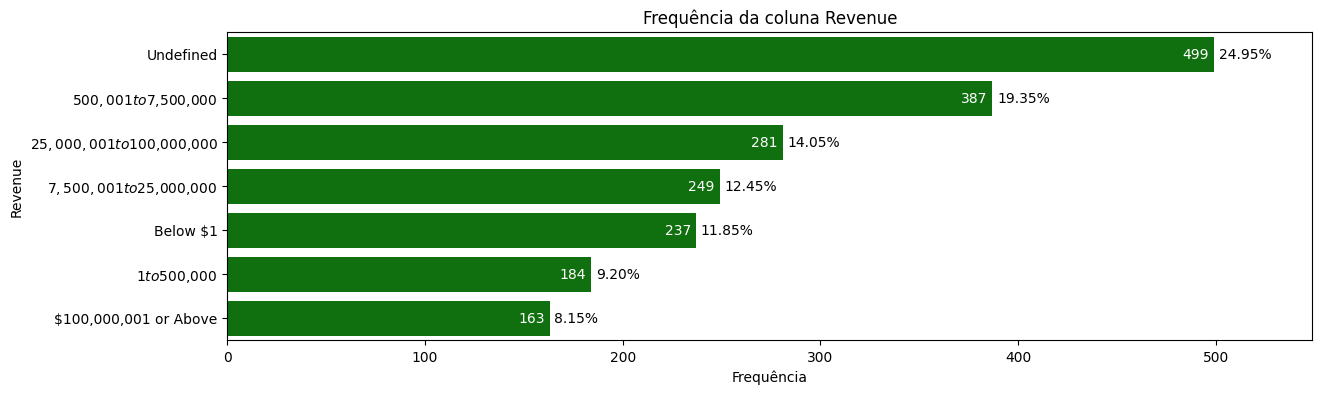

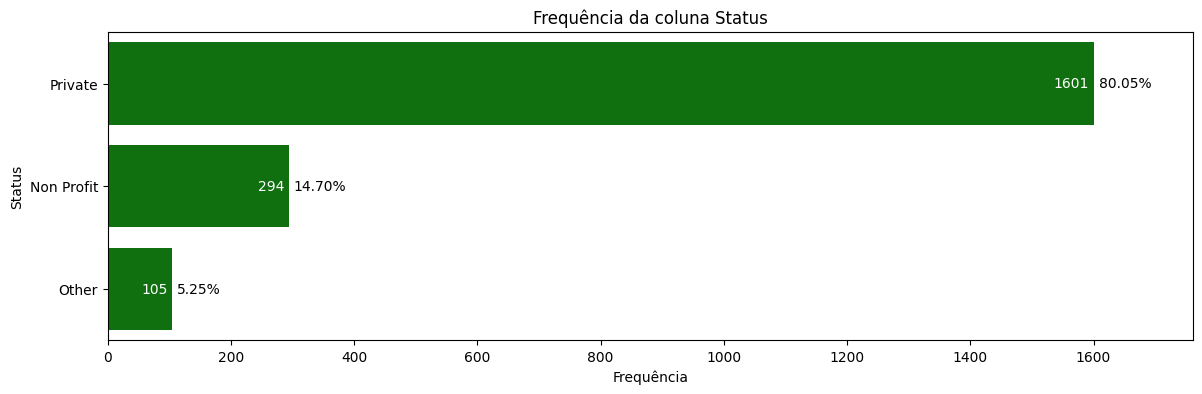

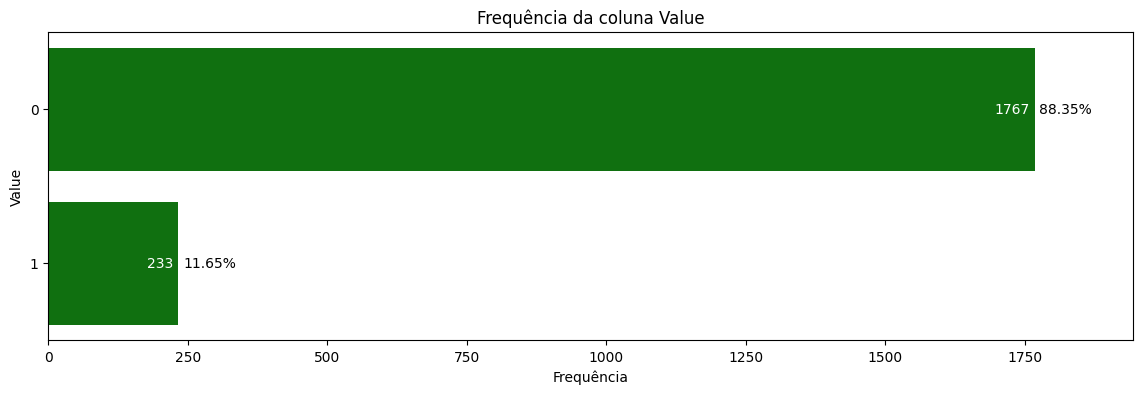

In [22]:
colunas_categoricas = ['City', 'Revenue', 'Status', 'Value']
for colunas in colunas_categoricas:
    barplot(train[colunas])

Número de outliers (excluídos): 0 (0.0% do total)
Número de registros considerados: 2000


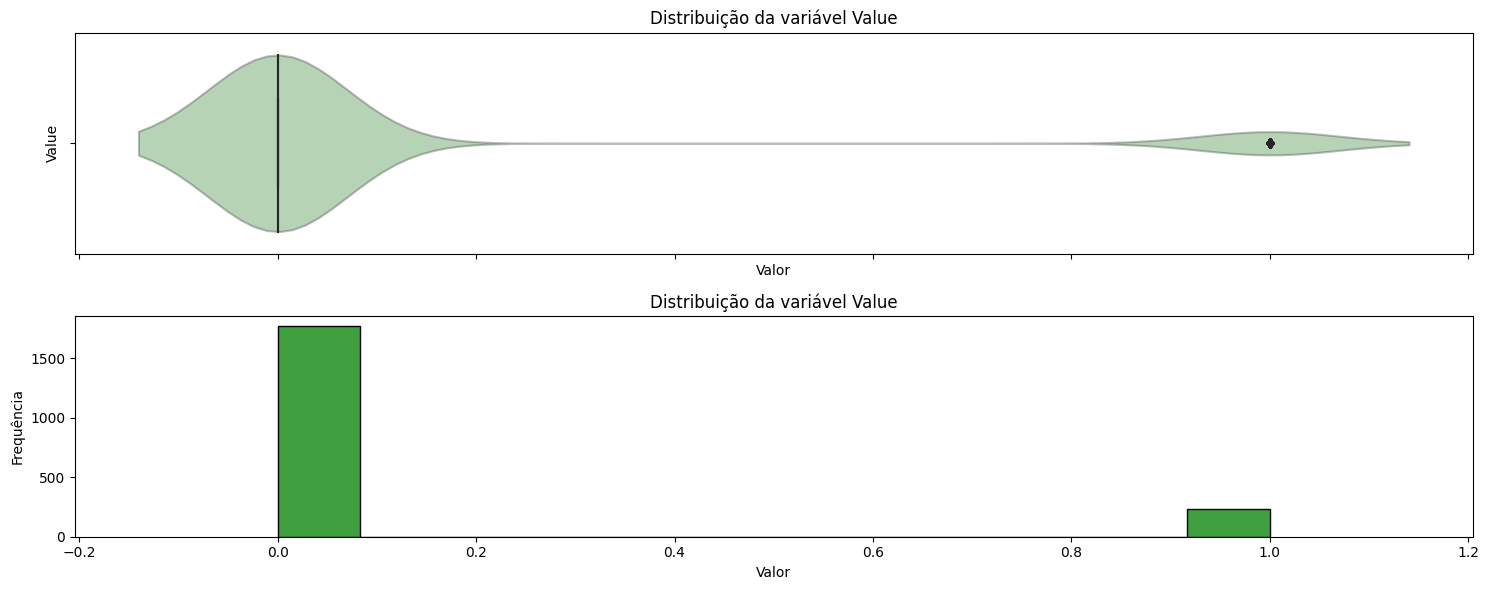

In [23]:
numeric_plot(train['Value'])

### Test

In [24]:
test = pd.read_csv(DATA_PATH / 'case_study_testing.csv')
test.head()

,City,Website,Revenue,Status,Value
0,Denver,https://mysunshare.com/,"$500,001 to $7,500,000",NaN,NaN
1,Yucca Valley,http://prototyp3.xyz,Undefined,NaN,NaN
2,New York,http://onyllc.com,"$7,500,001 to $25,000,000",NaN,NaN
3,Wilmington,http://www.nikangtx.com/,"$1 to $500,000",NaN,NaN
4,Kansas City,http://www.dtpizza.org,Undefined,NaN,NaN


In [25]:
caract_df(test)

Nº rows: 2000
Nº columns: 5
Nº duplicated rows: 0

Nº of missings*:
	Status: 2000 - 100.0%
	Value: 2000 - 100.0%
(*) Before processing


In [26]:
data_info = pd.concat([pd.DataFrame(test.dtypes).T.rename(index={0:'column type'}),pd.DataFrame(test.isnull().sum()).T.rename(index={0:'nº nulls'}),
                       pd.DataFrame(test.isnull().sum()/test.shape[0]*100).T.
                      rename(index={0:'% nulls'}),pd.DataFrame(test.nunique()).T.rename(index={0:'nº unique values'})])

data_info

,City,Website,Revenue,Status,Value
column type,object,object,object,float64,float64
nº nulls,0,0,0,2000,2000
% nulls,0.0,0.0,0.0,100.0,100.0
nº unique values,909,1997,7,0,0


Mostrando as maiores categorias de 909


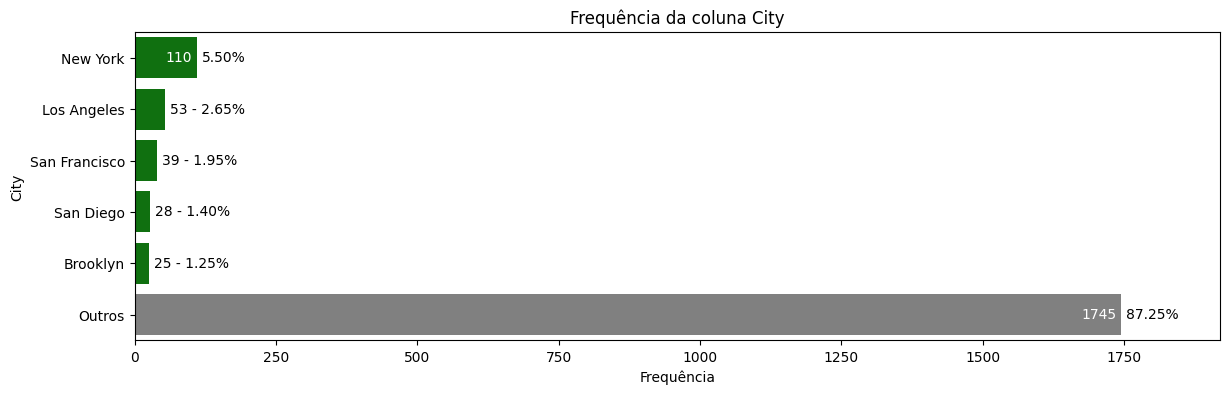

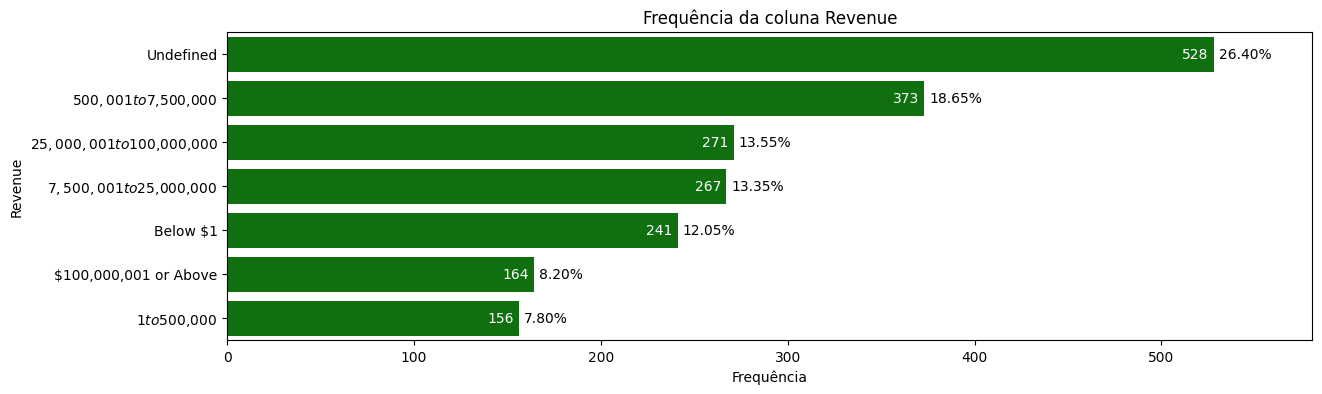

In [27]:
colunas_categoricas = ['City', 'Revenue']
for colunas in colunas_categoricas:
    barplot(test[colunas])

### Checking row in both datasets with equal City and Revenue.

In [28]:
duplicate_rows = train.merge(test, on=['Website', 'Revenue'], how='inner')

if not duplicate_rows.empty:
    print(f"Found {len(duplicate_rows)} row(s) with the same City and Revenue values in both datasets:")
    print(duplicate_rows)
else:
    print("No rows found with the same City and Revenue values in both datasets.")

Found 2 row(s) with the same City and Revenue values in both datasets:
           City_x                         Website                Revenue  \
0        Columbia    http://www.NelsonMullins.com  $100,000,001 or Above   
1  Webster Groves  https://www.seniorhelpers.com/              Undefined   

  Status_x  Value_x    City_y  Status_y  Value_y  
0    Other        0  Columbia       NaN      NaN  
1    Other        0   Venetia       NaN      NaN  


In [29]:
duplicate_rows = train.merge(test, on=['City', 'Revenue'], how='inner')

if not duplicate_rows.empty:
    print(f"Found {len(duplicate_rows)} row(s) with the same City and Revenue values in both datasets:")
    print(duplicate_rows)
else:
    print("No rows found with the same City and Revenue values in both datasets.")

Found 4471 row(s) with the same City and Revenue values in both datasets:
                  City                                  Website_x  \
0     Santa Fe Springs                   http://WWW.OXYHEALTH.COM   
1           Boca Raton                     https://hermanlaw.com/   
2           Boca Raton                     https://hermanlaw.com/   
3           Boca Raton          http://www.millennialpartners.com   
4           Boca Raton          http://www.millennialpartners.com   
...                ...                                        ...   
4466          San Jose                 http://www.retailnext.net/   
4467          San Jose                 http://www.retailnext.net/   
4468          San Jose                 http://www.retailnext.net/   
4469          Sarasota  https://www.synergyhealthdpc.com/contact/   
4470          Sarasota  https://www.synergyhealthdpc.com/contact/   

                          Revenue Status_x  Value_x  \
0       $7,500,001 to $25,000,000  Private

Then assigning Status and Value to test dataset for above cases

In [30]:
# check for rows with exact same City and Revenue values in both datasets
for index, row in test.iterrows():
    matching_rows = train[(train['City'] == row['City']) &
                               (train['Revenue'] == row['Revenue'])]
    if not matching_rows.empty:
        # copy the corresponding Status and Value values from the training dataset to the testing dataset
        test.at[index, 'Status'] = matching_rows.iloc[0]['Status']
        test.at[index, 'Value'] = matching_rows.iloc[0]['Value']

test

,City,Website,Revenue,Status,Value
0,Denver,https://mysunshare.com/,"$500,001 to $7,500,000",Private,0.0
1,Yucca Valley,http://prototyp3.xyz,Undefined,NaN,NaN
2,New York,http://onyllc.com,"$7,500,001 to $25,000,000",Private,0.0
3,Wilmington,http://www.nikangtx.com/,"$1 to $500,000",NaN,NaN
4,Kansas City,http://www.dtpizza.org,Undefined,Non Profit,0.0
...,...,...,...,...,...
1995,Miami,https://swapglobal.com/,Undefined,Private,0.0
1996,Concord,https://www.kantumpharma.com/,Undefined,NaN,NaN
1997,Houston,https://www.mydna.life/gene-by-gene-familytree...,"$25,000,001 to $100,000,000",Private,0.0
1998,Santa Clarita,http://www.blackknightllc.com,"$500,001 to $7,500,000",NaN,NaN


In [31]:
data_info = pd.concat([pd.DataFrame(test.dtypes).T.rename(index={0:'column type'}),pd.DataFrame(test.isnull().sum()).T.rename(index={0:'nº nulls'}),
                       pd.DataFrame(test.isnull().sum()/test.shape[0]*100).T.
                      rename(index={0:'% nulls'}),pd.DataFrame(test.nunique()).T.rename(index={0:'nº unique values'})])

data_info

,City,Website,Revenue,Status,Value
column type,object,object,object,object,float64
nº nulls,0,0,0,1181,1181
% nulls,0.0,0.0,0.0,59.05,59.05
nº unique values,909,1997,7,3,2


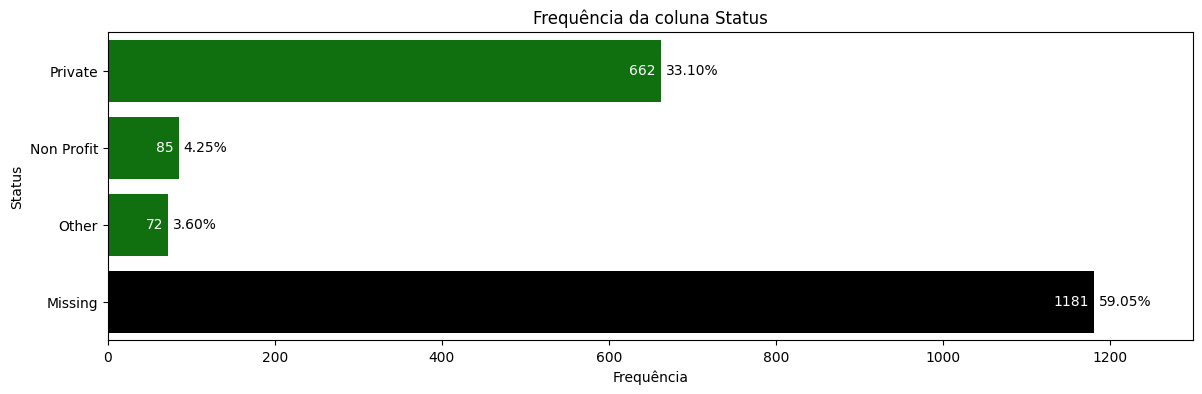

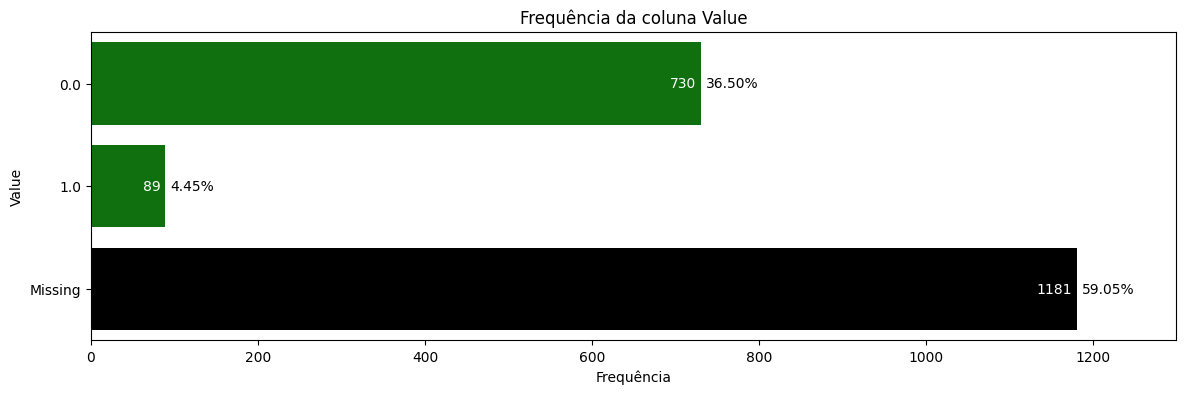

In [32]:
colunas_categoricas = ['Status', 'Value']
for colunas in colunas_categoricas:
    barplot(test[colunas])

### Clustering

Since we already filled some values within the test dataset, I will change our train and test datasets in order to cluster only the remaining ones.

In [33]:
new_test = test.loc[(test['Value'].isnull()) | (test['Status'].isnull())]
new_test.shape
# 1.181, 5

(1181, 5)

In [34]:
old_test = test.loc[(~test['Value'].isnull()) | (~test['Status'].isnull())]
old_test.shape
# 819, 5

(819, 5)

In [35]:
train = pd.concat([train, old_test])
train.shape

(2819, 5)

Mostrando as maiores categorias de 890


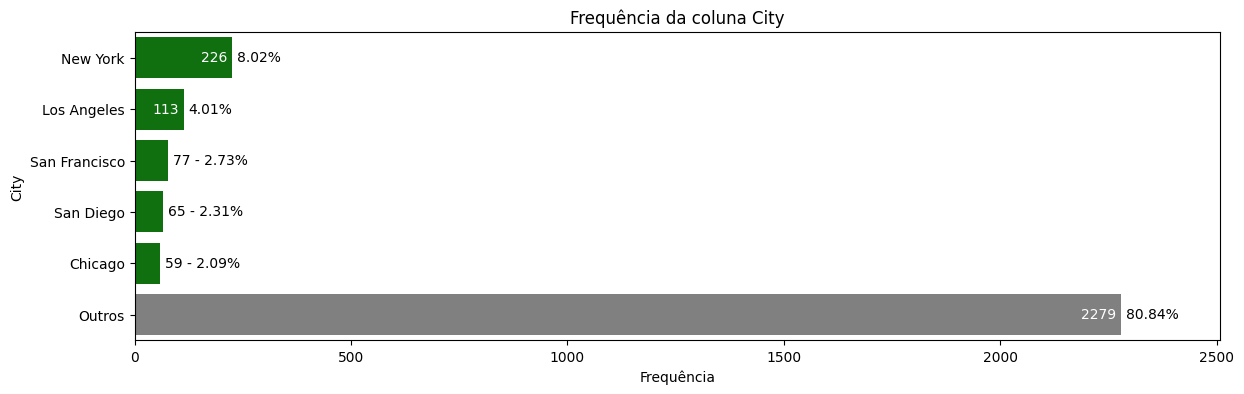

Mostrando as maiores categorias de 2808


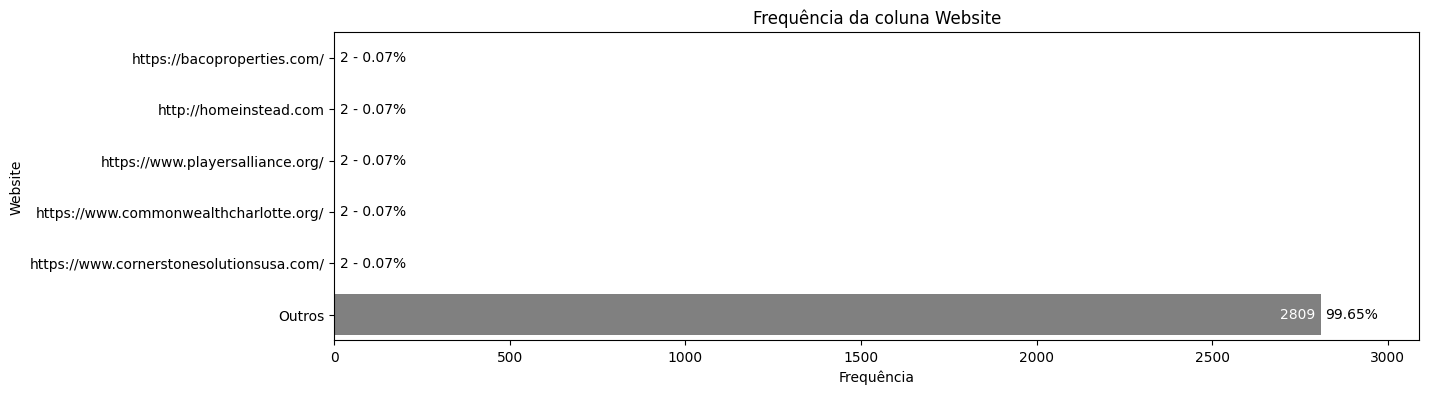

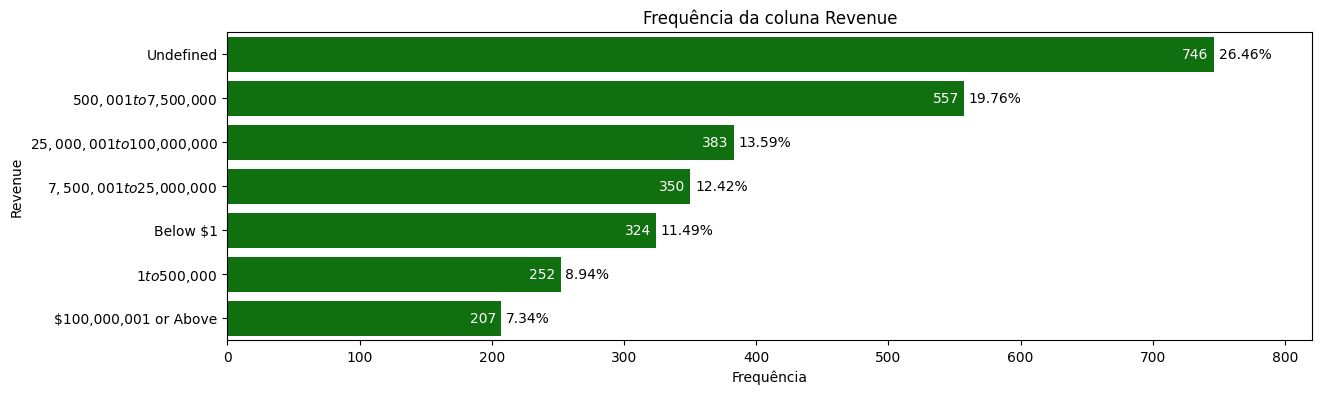

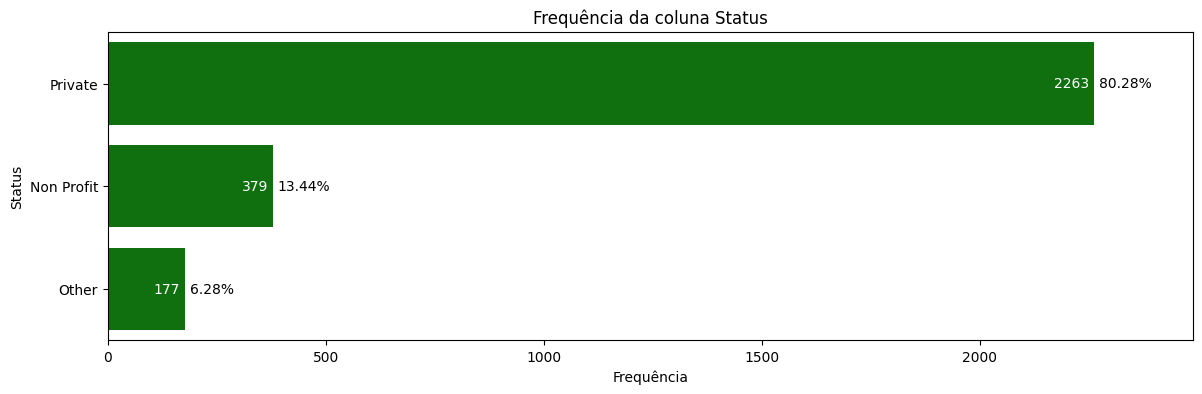

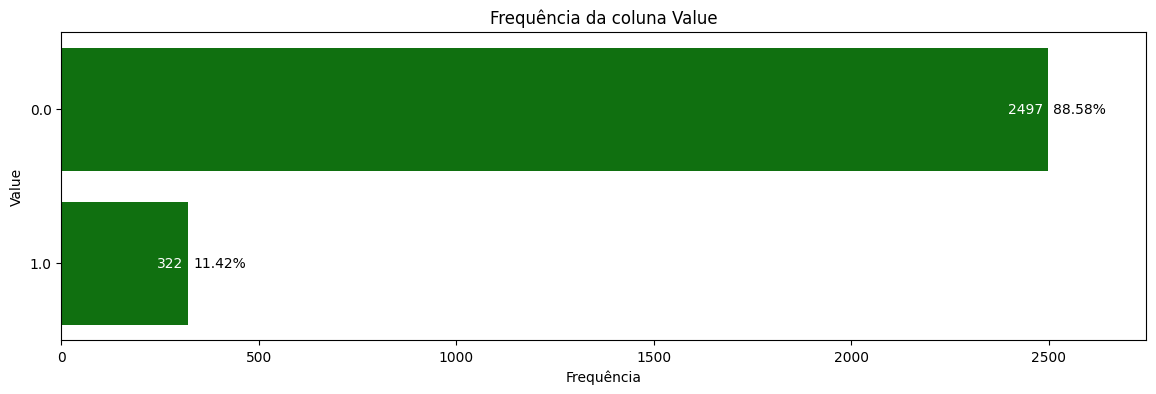

In [36]:
for colunas in train.columns:
    barplot(train[colunas])

Mostrando as maiores categorias de 823


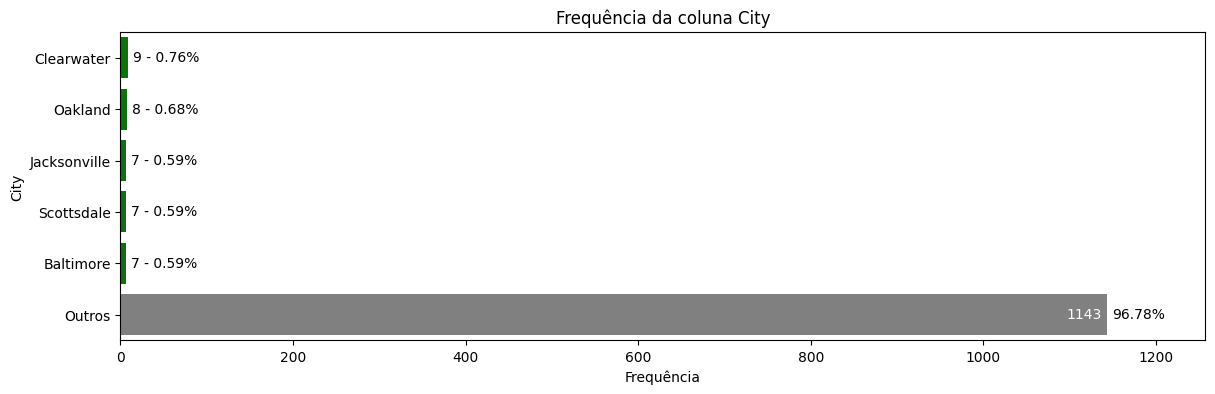

Mostrando as maiores categorias de 1178


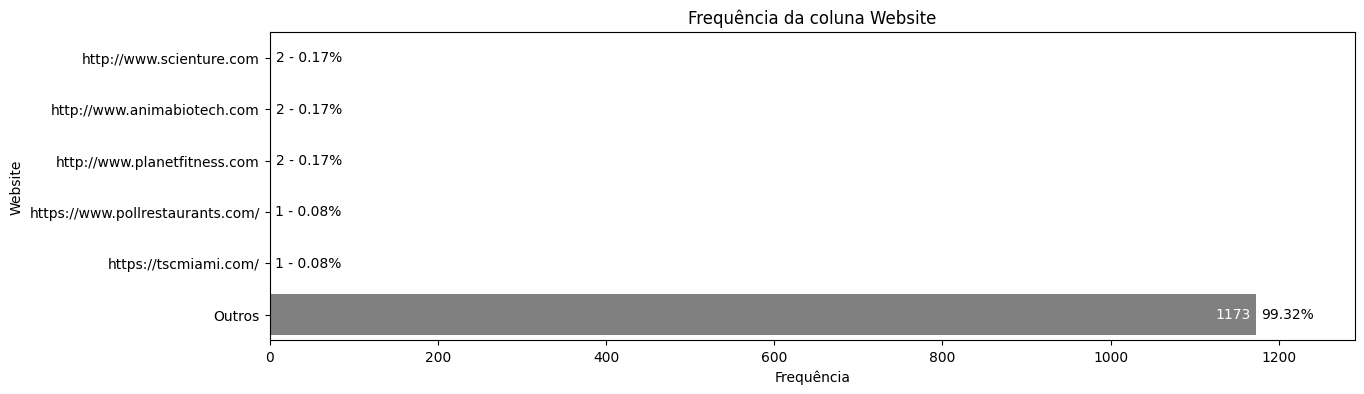

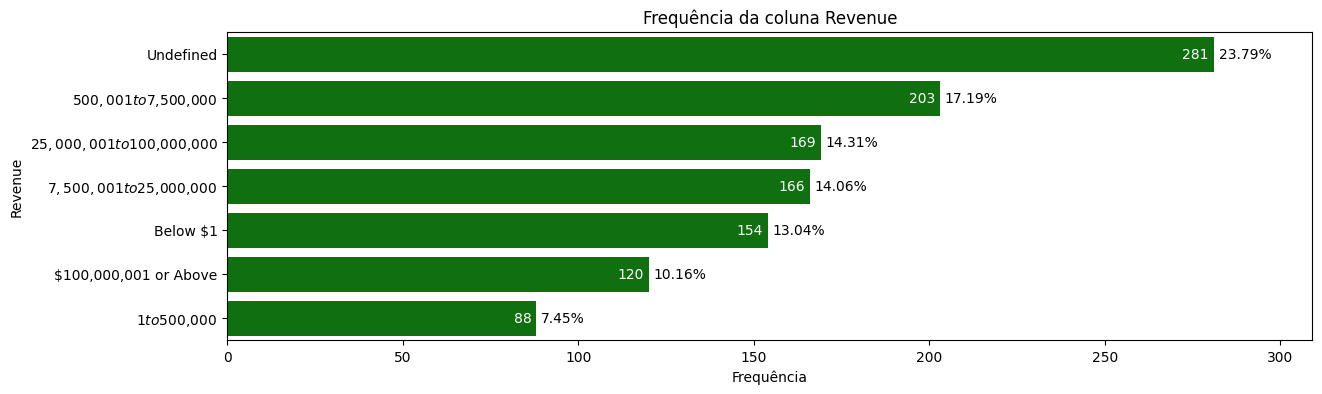

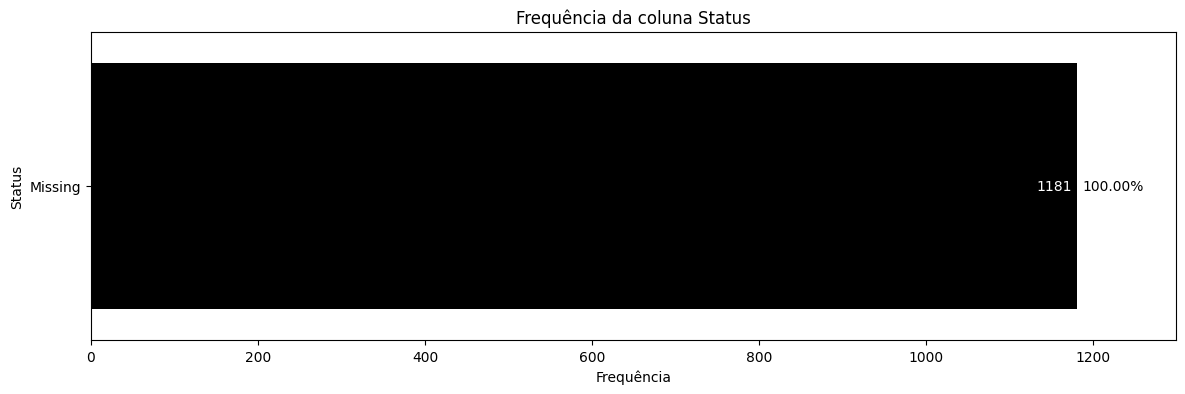

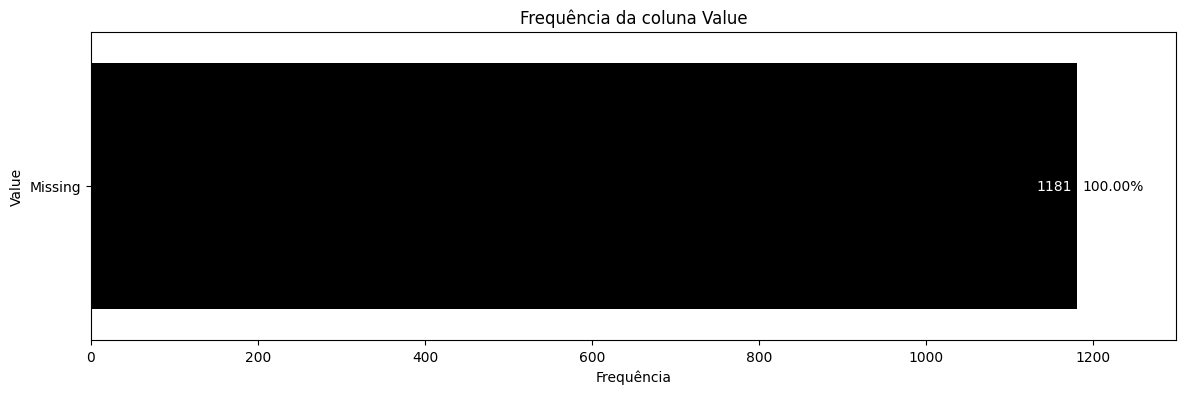

In [37]:
for colunas in new_test.columns:
    barplot(new_test[colunas])

We first try to label the remaining "Status"

In [44]:
train_df = train.copy()
test_df = new_test.copy()

# Split the data into X (features) and y (labels)
X_train = train_df.drop(['Status', 'Value', 'Website'], axis=1)
y_train = train_df[['Status']]
X_test = test_df.drop(['Status', 'Value', 'Website'], axis=1)

# Define the OneHotEncoder for the categorical columns
ct = ColumnTransformer(
    [('encoder', OneHotEncoder(handle_unknown='ignore'), ['City', 'Revenue'])],
    remainder='passthrough')

# Define the pipeline with KMeans
pipeline = Pipeline([
    ('transform', ct),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'kmeans__n_clusters': [3],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__max_iter': [100, 200, 300],
    'kmeans__tol': [0.0001, 0.001, 0.01]
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Use the best model to predict missing 'Status' and 'Value' values in the test set
y_pred = grid_search.predict(X_test)

# Create a new dataframe with the predicted 'Status' and 'Value' values
result_df = pd.DataFrame(y_pred, columns=['Status'])
result_df = result_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
# Merge the original test dataframe with the predicted values dataframe using the index
test_df = pd.concat([test_df.drop(['Status'], axis=1), result_df], axis=1)

# Print the resulting dataframe with filled 'Status' and 'Value' values
print(test_df)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
               City                            Website  \
0      Yucca Valley               http://prototyp3.xyz   
1        Wilmington           http://www.nikangtx.com/   
2        Greenville               https://wjcblaw.com/   
3          Sherwood           https://loennursery.com/   
4           Dubuque        https://www.hartigdrug.com/   
...             ...                                ...   
1176     Scottsdale      https://www.bluestargolf.com/   
1177    San Antonio  https://www.bigstateelectric.com/   
1178      Princeton    https://hiltonnj.com/wordpress/   
1179        Concord      https://www.kantumpharma.com/   
1180  Santa Clarita      http://www.blackknightllc.com   

                          Revenue  Value  Status  
0                       Undefined    NaN       1  
1                  $1 to $500,000    NaN       0  
2     $25,000,001 to $100,000,000    NaN       2  
3                       Undefined    N

In [47]:
test_df

,City,Website,Revenue,Value,Status
0,Yucca Valley,http://prototyp3.xyz,Undefined,NaN,1
1,Wilmington,http://www.nikangtx.com/,"$1 to $500,000",NaN,0
2,Greenville,https://wjcblaw.com/,"$25,000,001 to $100,000,000",NaN,2
3,Sherwood,https://loennursery.com/,Undefined,NaN,1
4,Dubuque,https://www.hartigdrug.com/,"$25,000,001 to $100,000,000",NaN,2
...,...,...,...,...,...
1176,Scottsdale,https://www.bluestargolf.com/,"$7,500,001 to $25,000,000",NaN,0
1177,San Antonio,https://www.bigstateelectric.com/,"$100,000,001 or Above",NaN,0
1178,Princeton,https://hiltonnj.com/wordpress/,Undefined,NaN,1
1179,Concord,https://www.kantumpharma.com/,Undefined,NaN,1


In [52]:
status_map = {0.0: "Private", 1.0: "Non Profit", 2.0: "Other"}
test_df["Status"] = test_df["Status"].map(status_map)

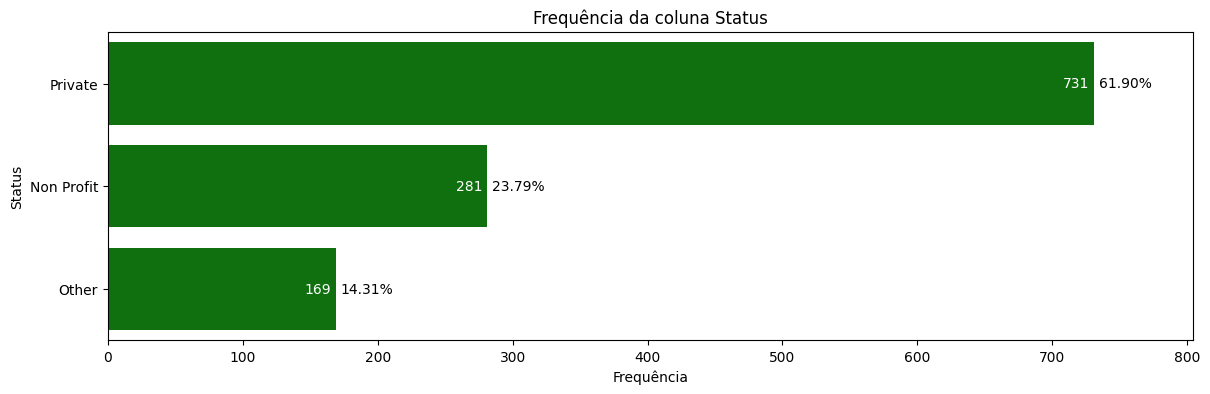

In [53]:
barplot(test_df['Status'])

In [54]:
# Split the data into X (features) and y (labels)
X_train = train_df.drop(['Value', 'Website'], axis=1)
y_train = train_df[['Value']]
X_test = test_df.drop(['Value', 'Website'], axis=1)

# Define the OneHotEncoder for the categorical columns
ct = ColumnTransformer(
    [('encoder', OneHotEncoder(handle_unknown='ignore'), ['City', 'Revenue', 'Status'])],
    remainder='passthrough')

# Define the pipeline with KMeans
pipeline = Pipeline([
    ('transform', ct),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'kmeans__n_clusters': [2],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__max_iter': [100, 200, 300],
    'kmeans__tol': [0.0001, 0.001, 0.01]
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Use the best model to predict missing 'Status' and 'Value' values in the test set
y_pred = grid_search.predict(X_test)

# Create a new dataframe with the predicted 'Status' and 'Value' values
result_df = pd.DataFrame(y_pred, columns=['Value'])

# Merge the original test dataframe with the predicted values dataframe using the index
test_df = pd.concat([test_df.drop(['Value'], axis=1), result_df], axis=1)

# Print the resulting dataframe with filled 'Status' and 'Value' values
print(test_df)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
               City                            Website  \
0      Yucca Valley               http://prototyp3.xyz   
1        Wilmington           http://www.nikangtx.com/   
2        Greenville               https://wjcblaw.com/   
3          Sherwood           https://loennursery.com/   
4           Dubuque        https://www.hartigdrug.com/   
...             ...                                ...   
1176     Scottsdale      https://www.bluestargolf.com/   
1177    San Antonio  https://www.bigstateelectric.com/   
1178      Princeton    https://hiltonnj.com/wordpress/   
1179        Concord      https://www.kantumpharma.com/   
1180  Santa Clarita      http://www.blackknightllc.com   

                          Revenue      Status  Value  
0                       Undefined  Non Profit      1  
1                  $1 to $500,000     Private      0  
2     $25,000,001 to $100,000,000       Other      0  
3                     

Mostrando as maiores categorias de 823


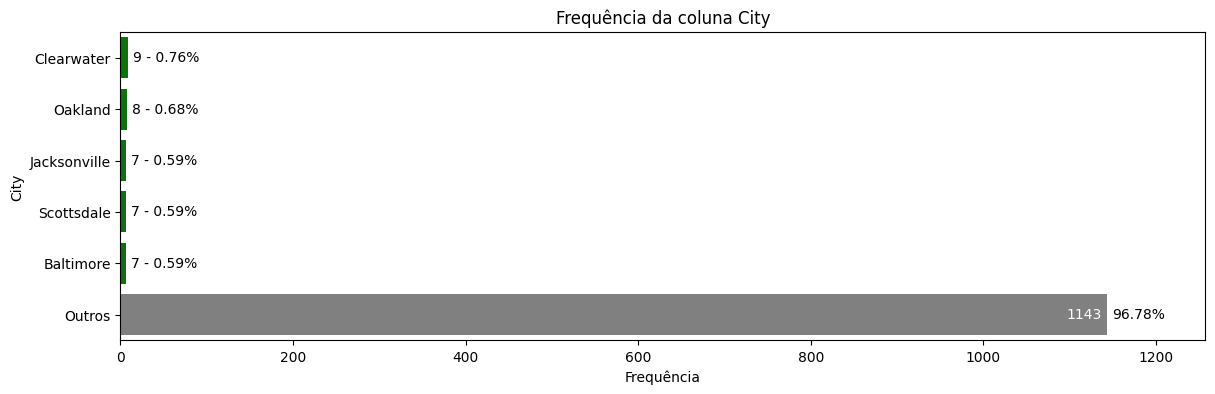

Mostrando as maiores categorias de 1178


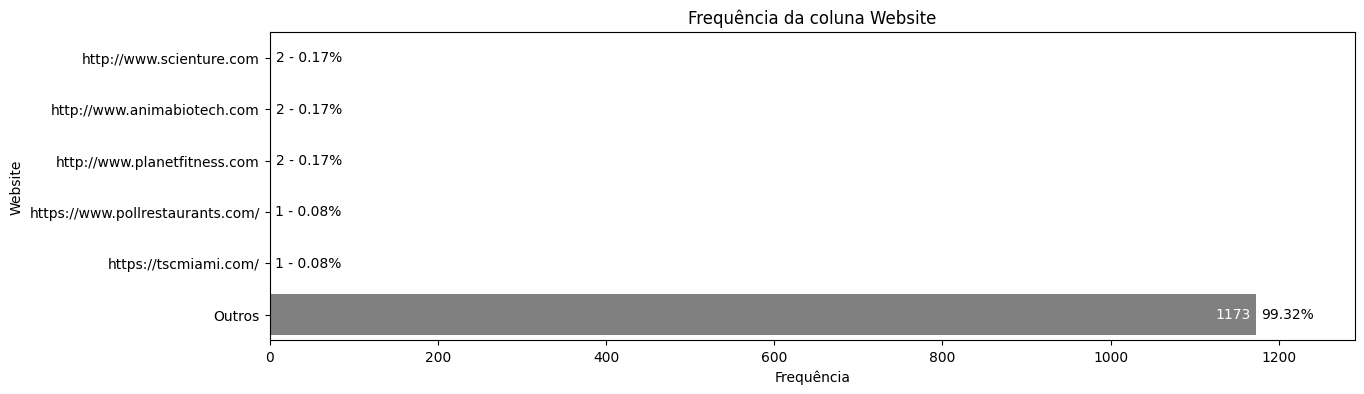

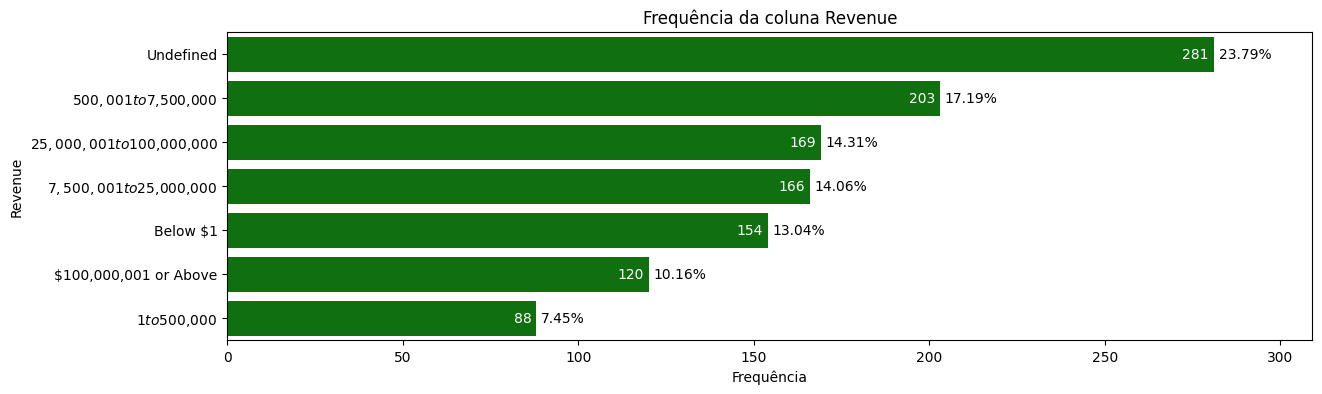

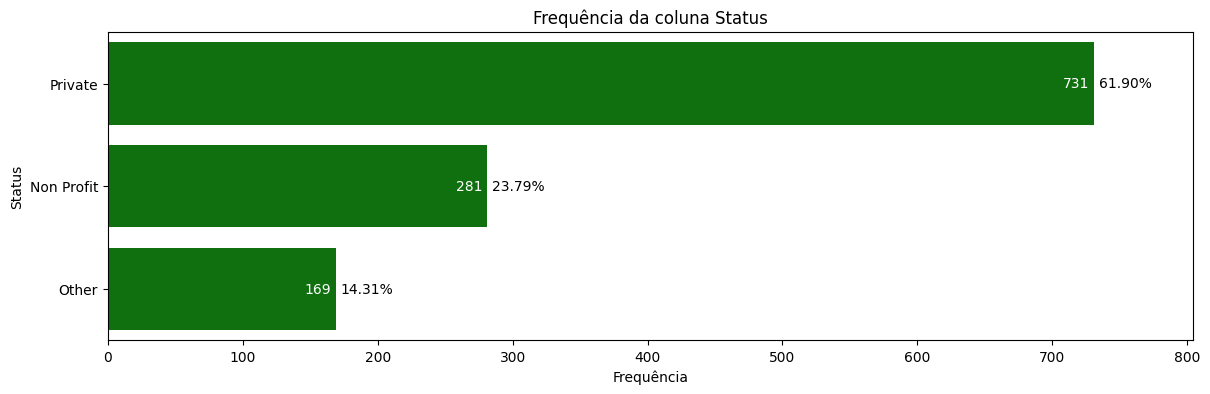

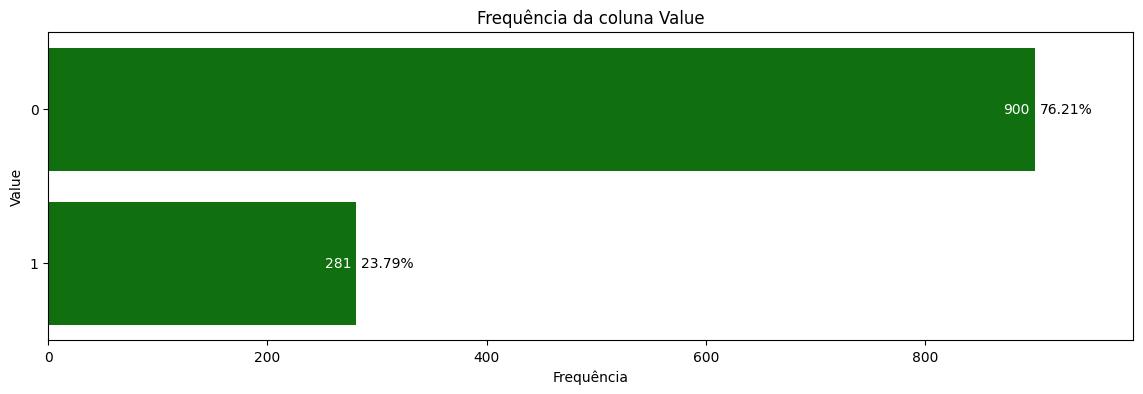

In [58]:
for colunas in train.columns:
    barplot(test_df[colunas])

In [60]:
result = pd.concat([old_test, test_df])
result

,City,Website,Revenue,Status,Value
0,Denver,https://mysunshare.com/,"$500,001 to $7,500,000",Private,0.0
2,New York,http://onyllc.com,"$7,500,001 to $25,000,000",Private,0.0
4,Kansas City,http://www.dtpizza.org,Undefined,Non Profit,0.0
5,Portland,https://sortis.com/,Undefined,Non Profit,0.0
7,Grand Rapids,http://www.burrcompany.com,Below $1,Other,0.0
...,...,...,...,...,...
1176,Scottsdale,https://www.bluestargolf.com/,"$7,500,001 to $25,000,000",Private,0.0
1177,San Antonio,https://www.bigstateelectric.com/,"$100,000,001 or Above",Private,0.0
1178,Princeton,https://hiltonnj.com/wordpress/,Undefined,Non Profit,1.0
1179,Concord,https://www.kantumpharma.com/,Undefined,Non Profit,1.0


Mostrando as maiores categorias de 909


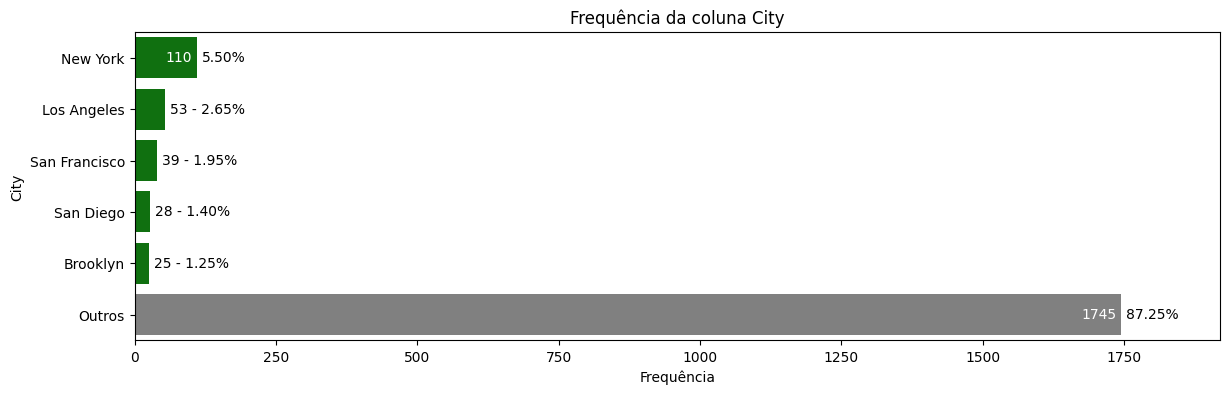

Mostrando as maiores categorias de 1997


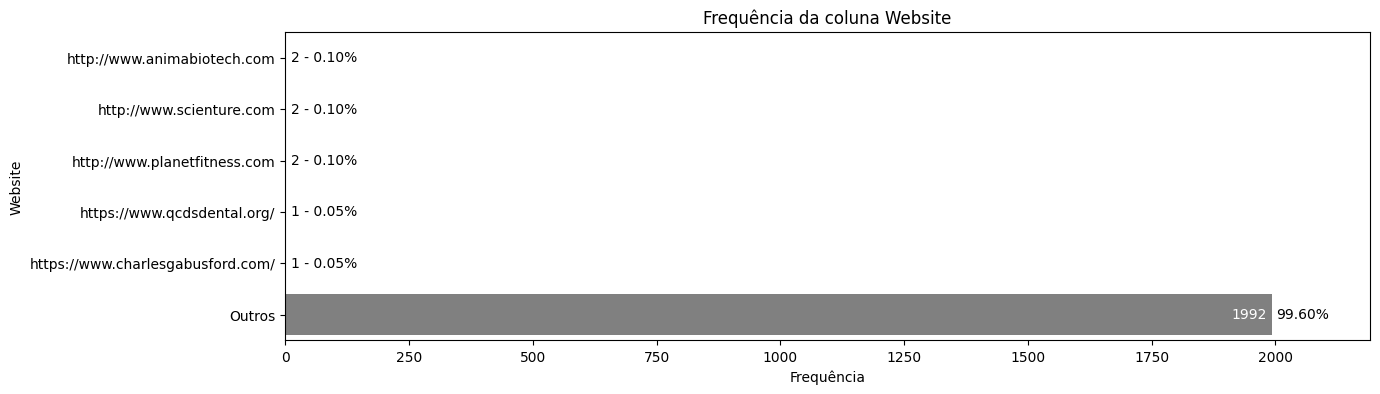

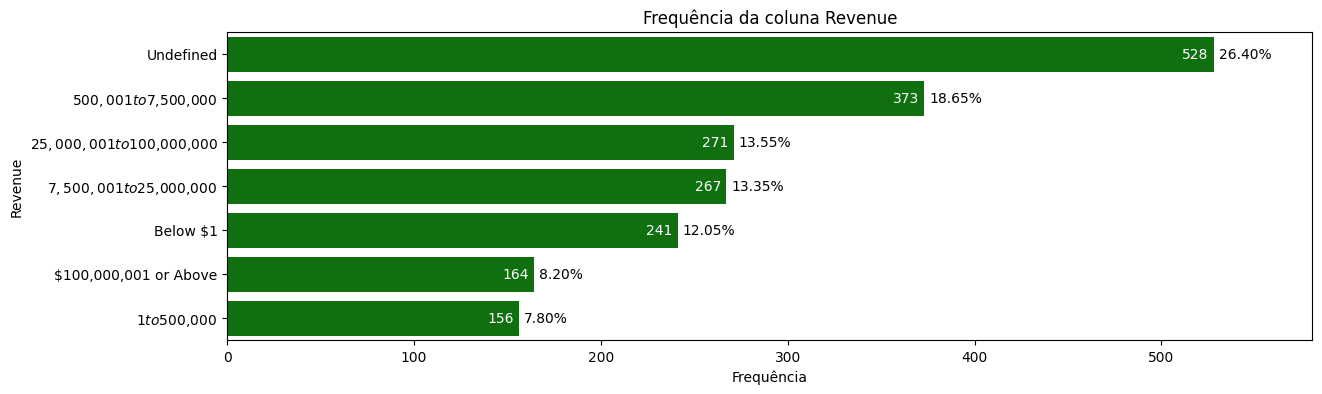

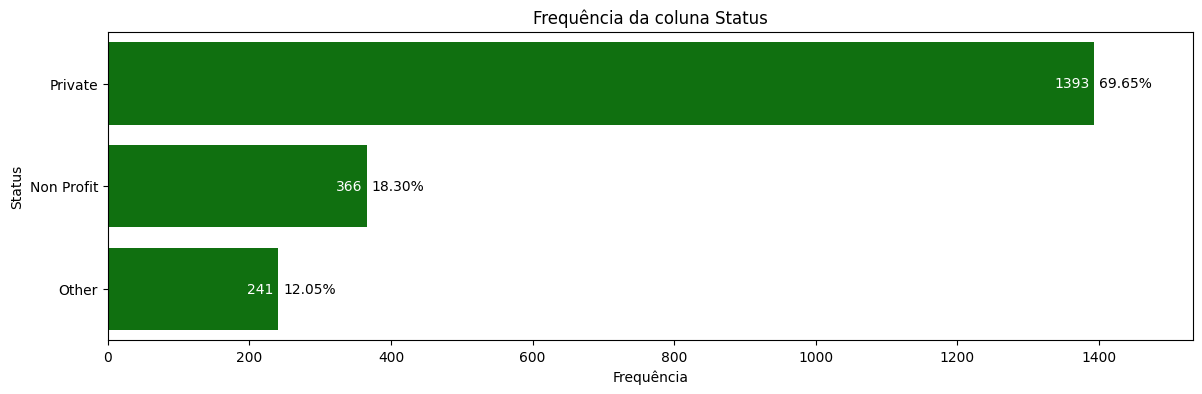

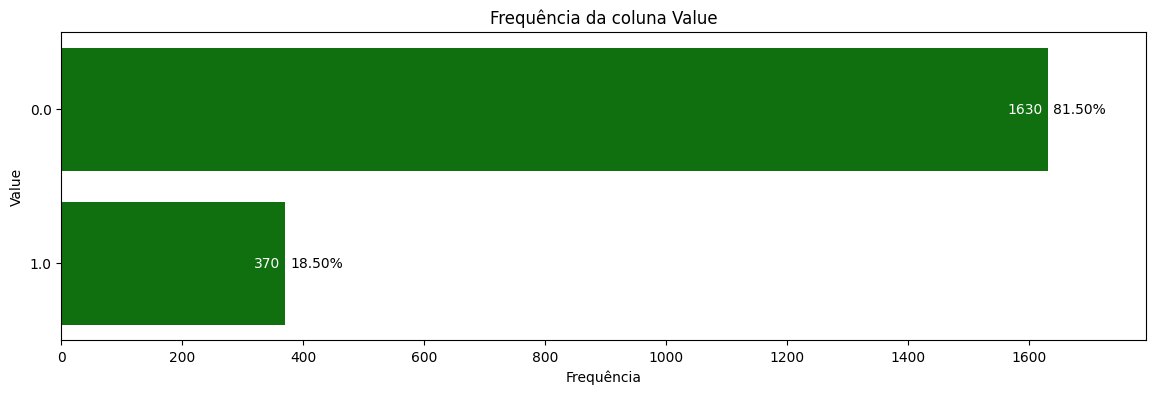

In [61]:
for colunas in train.columns:
    barplot(result[colunas])

In [62]:
result.shape

(2000, 5)

In [63]:
result.to_csv(DATA_PATH / 'testing_filled.csv')

My strategy was:
    1) Find exact "City" and "Revenue" matches in both dataframe, then fill testing df accordingly
    2) Now, we have a bigger training set, and we train a clustering (kmeans) algorithm first to the "Status" column, to fill it in the test df.
    3) With "Status" filled, we do the same for the "Value" column.
